In [3]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

# Stil für schöne Plots
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Pfad anpassen
path_data = "../data/processed/istdata_clean.parquet"

# Daten laden
lf = pl.scan_parquet(path_data)

# Wir brauchen für diese Analyse:
# 1. Nur Züge (keine Busse)
# 2. Ankunfts- und Abfahrtsverspätung
# 3. Den Bahnhof (HALTESTELLEN_NAME)
df_stations = (
    lf
    .filter(pl.col("PRODUKT_ID") == "Zug")
    .select([
        "HALTESTELLEN_NAME", 
        "ANKUNFTSZEIT", 
        "delay_arrival_s", 
        "delay_departure_s",
        "LINIEN_TEXT"  # <-- KORRIGIERT: LINIEN_TEXT statt LINIEN_ID
    ])
    # Verspätungen in Minuten umrechnen
    .with_columns([
        (pl.col("delay_arrival_s") / 60).alias("arr_delay_min"),
        (pl.col("delay_departure_s") / 60).alias("dep_delay_min")
    ])
    # Delta berechnen: Abfahrt - Ankunft
    # Negativ = Zeit gutgemacht (Puffer genutzt)
    # Positiv = Verspätung aufgebaut
    .with_columns(
        (pl.col("dep_delay_min") - pl.col("arr_delay_min")).alias("delta_delay")
    )
    # Extremwerte filtern (Datenfehler bereinigen)
    .filter(
        (pl.col("arr_delay_min").is_between(-30, 120)) &
        (pl.col("dep_delay_min").is_between(-30, 120))
    )
).collect().to_pandas()

print(f"Daten geladen: {len(df_stations)} Haltepunkte.")
df_stations.head()

Daten geladen: 4614598 Haltepunkte.


,HALTESTELLEN_NAME,ANKUNFTSZEIT,delay_arrival_s,delay_departure_s,LINIEN_TEXT,arr_delay_min,dep_delay_min,delta_delay
0,Schaffhausen,2025-01-09 05:54:00+00:00,114.0,78.0,IR3,1.900000,1.300000,-0.600000
1,Schaffhausen,2025-01-09 06:14:00+00:00,42.0,1.0,RE3,0.700000,0.016667,-0.683333
2,Schaffhausen,2025-01-09 06:58:00+00:00,31.0,17.0,IR3,0.516667,0.283333,-0.233333
3,Schaffhausen,2025-01-09 06:58:00+00:00,18.0,-2.0,RE3,0.300000,-0.033333,-0.333333
4,Schaffhausen,2025-01-09 07:58:00+00:00,83.0,20.0,IR3,1.383333,0.333333,-1.050000


# H12: Der "Puffer-Effekt" an Bahnhöfen

### 1. Forschungsfrage
Haben grosse Bahnhöfe (Knotenpunkte/Hubs) eine stärkere **"Selbstheilungskraft"** für das Netz als kleine Bahnhöfe?
Wir untersuchen, ob die **Grösse eines Bahnhofs** (gemessen an der Anzahl der Zughalte) mit seiner Fähigkeit korreliert, Verspätungen abzubauen.

**Metrik:**
Wir definieren $\Delta_{Delay}$ als die Differenz zwischen Abfahrts- und Ankunftsverspätung:
$$\Delta_{Delay} = Verspätung_{Ab} - Verspätung_{An}$$
* $\Delta < 0$: Der Zug fährt pünktlicher ab als er ankam (Zeit gutgemacht / Puffer genutzt).
* $\Delta > 0$: Der Zug sammelt am Bahnhof zusätzliche Verspätung an.

### 2. Hypothesen
* **Nullhypothese ($H_0$):**
    Es gibt keinen Zusammenhang zwischen der Bahnhofsgröße (Anzahl Züge) und dem Verspätungsabbau ($\Delta_{Delay}$).
    $$\rho(Grösse, \Delta) = 0$$

* **Alternativhypothese ($H_1$):**
    Grosse Bahnhöfe bauen signifikant mehr Verspätung ab als kleine (negative Korrelation), da sie längere Haltezeiten und Puffer in den Fahrplan eingebaut haben.
    $$\rho(Grösse, \Delta) < 0$$

**Niveau:** $\alpha = 0.05$

In [4]:
# 3. Datenaggregation pro Bahnhof
# Wir nutzen Pandas für die Aggregation der materialisierten Daten
station_stats = (
    df_stations
    .groupby("HALTESTELLEN_NAME")
    .agg(
        anzahl_zuege=("LINIEN_TEXT", "count"),
        mean_arr_delay=("arr_delay_min", "mean"),
        mean_delta_delay=("delta_delay", "mean")
    )
    .reset_index()
)

# FILTER: Wir entfernen winzige Haltestellen (z.B. < 100 Fahrten im Monat),
# da diese das Bild verzerren (zu hohe Varianz).
station_stats_filtered = station_stats[station_stats["anzahl_zuege"] > 100].copy()

print(f"Analysiere {len(station_stats_filtered)} Bahnhöfe (nach Filter).")
# Zeige die grössten Bahnhöfe (Hubs)
print("\nDie grössten Bahnhöfe im Datensatz:")
print(station_stats_filtered.sort_values("anzahl_zuege", ascending=False).head(5))

Analysiere 1695 Bahnhöfe (nach Filter).

Die grössten Bahnhöfe im Datensatz:
     HALTESTELLEN_NAME  anzahl_zuege  mean_arr_delay  mean_delta_delay
1740         Zürich HB         66858        1.144408          0.014258
124               Bern         47108        0.622926          0.424801
1675        Winterthur         29123        0.934353          0.288977
1744   Zürich Oerlikon         26728        1.049805          0.179273
917             Luzern         24613        0.781613          0.287358


Spearman-Korrelation: 0.1217
p-Wert: 5.0443e-07
ERGEBNIS: Kein signifikanter Puffer-Effekt nachweisbar.


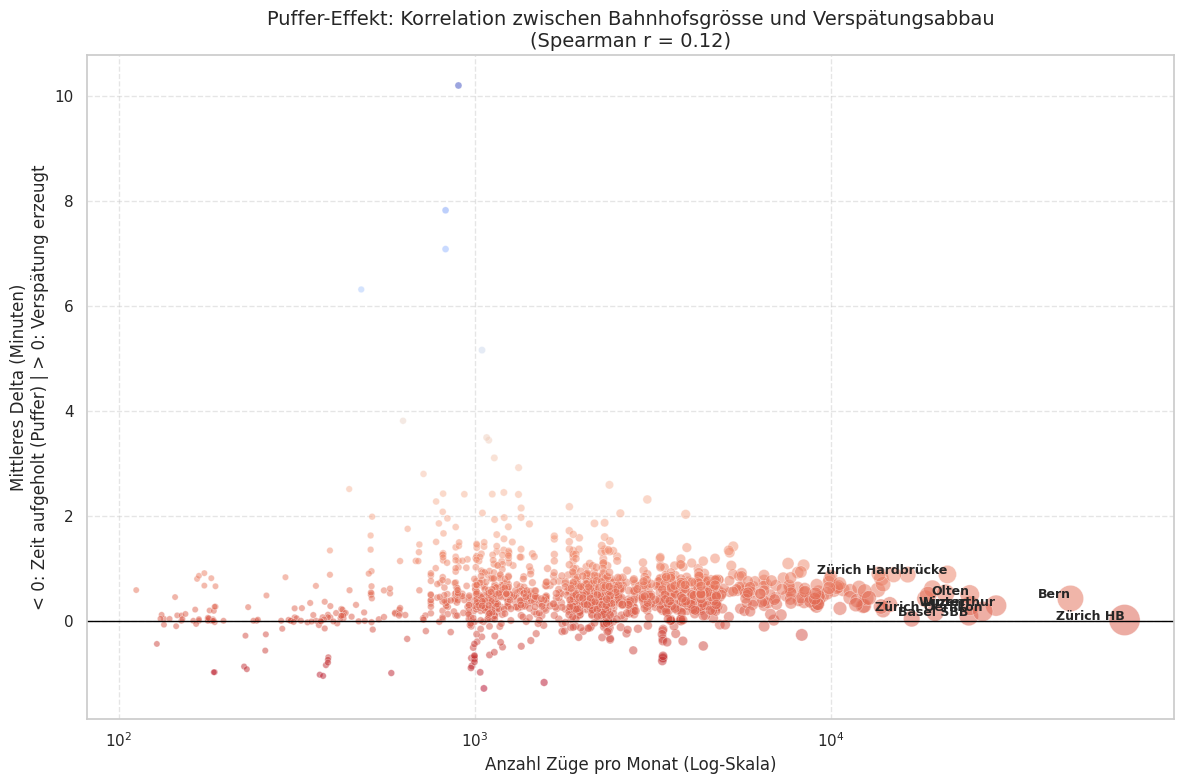

In [5]:
# 4. Hypothesentest & Visualisierung

# A) Statistische Korrelation (Spearman, da Daten nicht zwingend linear/normalverteilt)
corr, p_val = stats.spearmanr(
    station_stats_filtered["anzahl_zuege"], 
    station_stats_filtered["mean_delta_delay"]
)

print(f"Spearman-Korrelation: {corr:.4f}")
print(f"p-Wert: {p_val:.4e}")

# Entscheidung
if p_val < 0.05 and corr < 0:
    print("ERGEBNIS: Signifikante negative Korrelation. Grössere Bahnhöfe bauen mehr Verspätung ab!")
else:
    print("ERGEBNIS: Kein signifikanter Puffer-Effekt nachweisbar.")


# B) Der Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=station_stats_filtered,
    x="anzahl_zuege",
    y="mean_delta_delay",
    alpha=0.5,
    size="anzahl_zuege",
    sizes=(20, 500), # Punktegröße nach Bahnhofsgröße
    hue="mean_delta_delay",
    palette="coolwarm_r", # Blau = Gut (Abbau), Rot = Schlecht (Aufbau)
    legend=False
)

# Logarithmische X-Achse für bessere Darstellung der Größenordnungen
plt.xscale("log")
plt.axhline(0, color='black', linestyle='-', linewidth=1)

# Beschriftung der wichtigsten "Player" (Top 5 Grösse + Extremwerte)
top_hubs = station_stats_filtered.nlargest(8, "anzahl_zuege")
for i, row in top_hubs.iterrows():
    plt.text(
        row['anzahl_zuege'], 
        row['mean_delta_delay'], 
        row['HALTESTELLEN_NAME'], 
        fontsize=9, 
        ha='right', 
        fontweight='bold'
    )

plt.title(f"Puffer-Effekt: Korrelation zwischen Bahnhofsgrösse und Verspätungsabbau\n(Spearman r = {corr:.2f})", fontsize=14)
plt.xlabel("Anzahl Züge pro Monat (Log-Skala)", fontsize=12)
plt.ylabel("Mittleres Delta (Minuten)\n< 0: Zeit aufgeholt (Puffer) | > 0: Verspätung erzeugt", fontsize=12)
plt.grid(True, which="major", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

### 5. Fazit

Wir haben untersucht, ob grosse Bahnhöfe als "Puffer" im System wirken.

**Ergebnisse:**
1.  **Korrelation:** Der Spearman-Koeffizient von **0.12** ist leicht positiv und der p-Wert signifikant ($p < 0.05$).
2.  **Interpretation:**
    * Das positive Vorzeichen **widerlegt** die Hypothese eines Puffer-Effekts: Es gibt keinen Trend, dass grössere Bahnhöfe (rechts im Plot) Verspätungen systematisch abbauen (unten im Plot).
    * Grosse Knotenpunkte wie **Zürich HB, Bern oder Basel SBB** liegen tendenziell auf der 0-Linie oder leicht im positiven Bereich.
    * Das bedeutet: Trotz theoretischer Pufferzeiten schaffen es diese Bahnhöfe im Durchschnitt nicht, Zeit aufzuholen.

**Schlussfolgerung:**
Es ist **kein signifikanter Puffer-Effekt** nachweisbar. Die operative Komplexität an grossen Bahnhöfen (hohe Zugdichte, Umsteigeprozesse, Kreuzungskonflikte) scheint die theoretischen Zeitreserven aufzuzehren. Grosse Bahnhöfe wirken in der Praxis nicht als Stabilisatoren, die Verspätungen "schlucken", sondern geben diese eher neutral weiter oder verstärken sie minimal.